<a href="https://colab.research.google.com/github/DavoodSZ1993/Pytorch_Basics/blob/main/5_mlp_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `nn.ReLU()` vs. `nn.functional.relu()`:

* `nn.ReLU`: Creates an `nn.Module` which can be added to an `nn.Sequential` model.
* `nn.functional.relu()`: Is just the functional API call to the relu function. So it can be added in forward method.

## `tensor.backward()`

Computes the gradient of the current tensor w.r.t.  graph leaves.

* By default, PyTorch expects `backward()` to be called for the **last** output of the network, **the loss function**.
* By default, `backward()` is called on a **scalar tensor** and expects no arguments.  

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

In [16]:
a = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], requires_grad=True)
b = a * a

b.backward(a)
print(a.grad)

tensor([[ 2.,  8., 18.],
        [32., 50., 72.]])


* In the above code snippet, the `backward()` is called on a 2x3 `b` tensor (no longer a scalar). Mathematically, `a.grad` should be a 2x3x2x3 tensor as follows:
$$
db[i, j] \over da[k, l]
$$
* PyTorch does not support this **non-scalar** function derivatives. Instead, PyTorch assumes `b` is only an intermediate tensor and **somewhere upstream there is a loss function**.
* The upstream loss function through **chain rule** provides the following:
$$
d loss[i,j]\over db[i,j] 
$$
* The upstream gradient is of size 2x3 and this is actually the argument provided for `backward()`. In this case, `b.backward(g)`, where:
$$
g[i,j] = {d loss \over db[i,j]}
$$
* The gradients then is calculated by the chain rule:
$$
{d loss \over da[i,j]} = {dloss \over db[i,j]} \times {db[i,j] \over da[i,j]}
$$

* So, if we initiate the term `g`($dloss \over db[i,j]$) to the 1, then we can calculate the correct gradient.

* `torch.ones_like()`: Returns a tesnor filled with the scalar value 1, with the same size as `input`.
* `x.grad.data.zero(_)`: Since the `backward()` function accumulates gradients, we should not mix up gradients between minibatches, so we have to zero out the gradients by this command.

Text(0, 0.5, ' 2 x grad of relue')

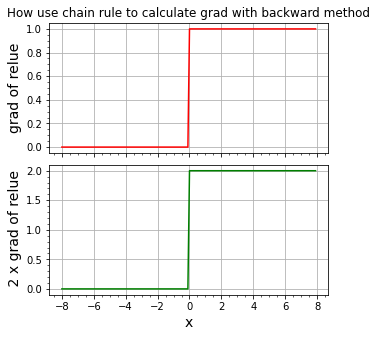

In [22]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)


fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(4, 4)

y.backward(torch.ones_like(x), retain_graph=True)
first_plot = fig.add_subplot(gs[0:2, 0:4])
plt.plot(x.detach(), x.grad, c= 'r')
plt.grid()
plt.minorticks_on()
plt.tick_params(labelbottom=False)
plt.ylabel('grad of relue', fontsize=14)
plt.title('How use chain rule to calculate grad with backward method')

x.grad.data.zero_()
y.backward(torch.ones_like(x) * 2, retain_graph=True)    # in the cahin rule, calculates 2 x gradient (as dicussed above!)
first_plot = fig.add_subplot(gs[2:4, 0:4])
plt.plot(x.detach(), x.grad, c='g')
plt.grid()
plt.minorticks_on()
plt.xlabel('x', fontsize=14)
plt.ylabel(' 2 x grad of relue', fontsize=14)


## `retain_graph` Argument in the `backward()` Method: 

Consider the following code snippet that contains a graph. In this graph, `d` and `e` are outputs and `a` is input.

In [24]:
a = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], requires_grad=True)

b = a**2
c = b*2
d = c.mean()
e = c.sum()
d, e

(tensor(30.3333, grad_fn=<MeanBackward0>),
 tensor(182., grad_fn=<SumBackward0>))

* When we do `d.backward()`, that is fine. However, after this computation the part of the graph that calculate `d` will be freed by default to save memory. 
* So, if we do `e.backward()`, the error message will pop up. In order to do `e.backward()`, we have to set the parameter `retain_graph` to `True` in `e.backward()`.
* This is very useful when we have to output branches in our network and want to calculate the loss function for both of them. 

In [25]:
d.backward(retain_graph=True)
e.backward(retain_graph=True)